In [1]:
from config import host, database, user, password
from sqlalchemy import create_engine
import geoalchemy2
import pandas as pd
import geopandas as gpd
import osgb
import re
import numpy as np

#### Create sqlalchemy connection engine using credentials from config file. With setting Echo=True, engine will log every query.

In [16]:
conn_str = f"postgresql://{user}:{password}@{host}/{database}"
engine = create_engine(conn_str, echo=True)
connection = engine.connect()
metadata = MetaData()

2020-12-07 10:17:58,668 INFO sqlalchemy.engine.base.Engine select version()
2020-12-07 10:17:58,671 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 10:17:58,711 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-12-07 10:17:58,712 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 10:17:58,745 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-07 10:17:58,746 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 10:17:58,760 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-07 10:17:58,761 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 10:17:58,777 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-12-07 10:17:58,778 INFO sqlalchemy.engine.base.Engine {}


#### Import csv as pandas dataframe. Using cp1252 encoding to avoid UTF-8 error

In [17]:
df = pd.read_csv("sitesummary.csv", encoding="cp1252")

#### Cleaning columns, removing unwanted, converting to lower case and changing space to underscore

In [18]:
df = df.drop([i for i in df.columns if 'Unnamed' in i], axis=1)
df = df.rename(columns=str.lower)
df.columns = df.columns.str.replace(' ', '_')

#### Removing rows with no osgr, uid, strip whitespace from osgr

In [20]:
df = df[~df['grid_reference'].isnull()]
df = df[~df['uid'].isnull()]
df = df.astype({'grid_reference': 'string'})
df['grid_reference'] = df['grid_reference'].str.replace(' ', '')

#### use parse_grid to convert osgr to easting/northing, null for values that don't match regex

In [108]:
df['easting'] = df['grid_reference'].apply(lambda x: osgb.parse_grid(x)[0] if re.match(r'[a-zA-Z]{2}\d{6,10}', str(x)) is not None else np.nan)
df['northing'] = df['grid_reference'].apply(lambda x: osgb.parse_grid(x)[1] if re.match(r'[a-zA-Z]{2}\d{6,10}', str(x)) is not None else np.nan)


#### Convert to geodataframe with EPSG:27700, remove any empty geometry

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.easting, df.northing), crs='EPSG:27700')
gdf = gdf[~gdf.geometry.is_empty]

#### gdf to postgis table, 'replace' will drop existing table if it already exists

In [70]:
gdf.to_postgis(name='site_summary', schema='public', con=engine, if_exists='replace')

#### test plot to check table imported correctly

2021-01-13 18:08:28,744 INFO sqlalchemy.engine.base.Engine select version()
2021-01-13 18:08:28,747 INFO sqlalchemy.engine.base.Engine {}
2021-01-13 18:08:28,798 INFO sqlalchemy.engine.base.Engine select current_schema()
2021-01-13 18:08:28,799 INFO sqlalchemy.engine.base.Engine {}
2021-01-13 18:08:28,843 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-01-13 18:08:28,843 INFO sqlalchemy.engine.base.Engine {}
2021-01-13 18:08:28,864 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-01-13 18:08:28,864 INFO sqlalchemy.engine.base.Engine {}
2021-01-13 18:08:28,886 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2021-01-13 18:08:28,886 INFO sqlalchemy.engine.base.Engine {}
2021-01-13 18:08:28,959 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

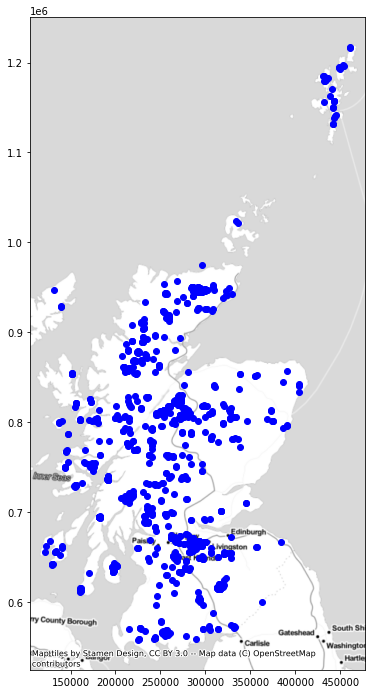

In [6]:
from config import host, database, user, password
from sqlalchemy import create_engine
import geoalchemy2
import geopandas as gpd
import contextily as ctx

'''
Basic shell script to read geometry data from postgres
'''

# create sqlalchemy engine to connect to db, note you will need to enter personal credentials in config.py
conn_str = f"postgresql://{user}:{password}@{host}/{database}"
engine = create_engine(conn_str, echo=True)
connection = engine.connect()

# enter SQL query
sql = """SELECT uid, geometry FROM site_summary"""

# read as geodataframe using geopandas library
gdf = gpd.read_postgis(sql, connection, geom_col='geometry', crs='EPSG:27700')

# remove empty geometries to avoid key error
gdf = gdf[~gdf.geometry.is_empty]

# test plot of data
ax = gdf.plot(color="blue", figsize=(12, 12))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=gdf.crs.to_string())